In [ ]:
#@title pip添加必需的包 pip install
!pip install scikit-learn
!pip install numpy
!pip install vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=102f4cb64fef294eff22efc48c9a36e9bb8ead8e48085d8935483731603ba4ec
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.5 MB/s eta 0:00:00


In [ ]:
#@title self-attention机制
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

class SelfAttention(Layer):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm = LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        attention_output = self.attention(inputs, inputs) #顺序为query,value,key,key缺省,则key=value
        attention_output = self.norm(inputs + attention_output)
        return attention_output

Overview of MMTV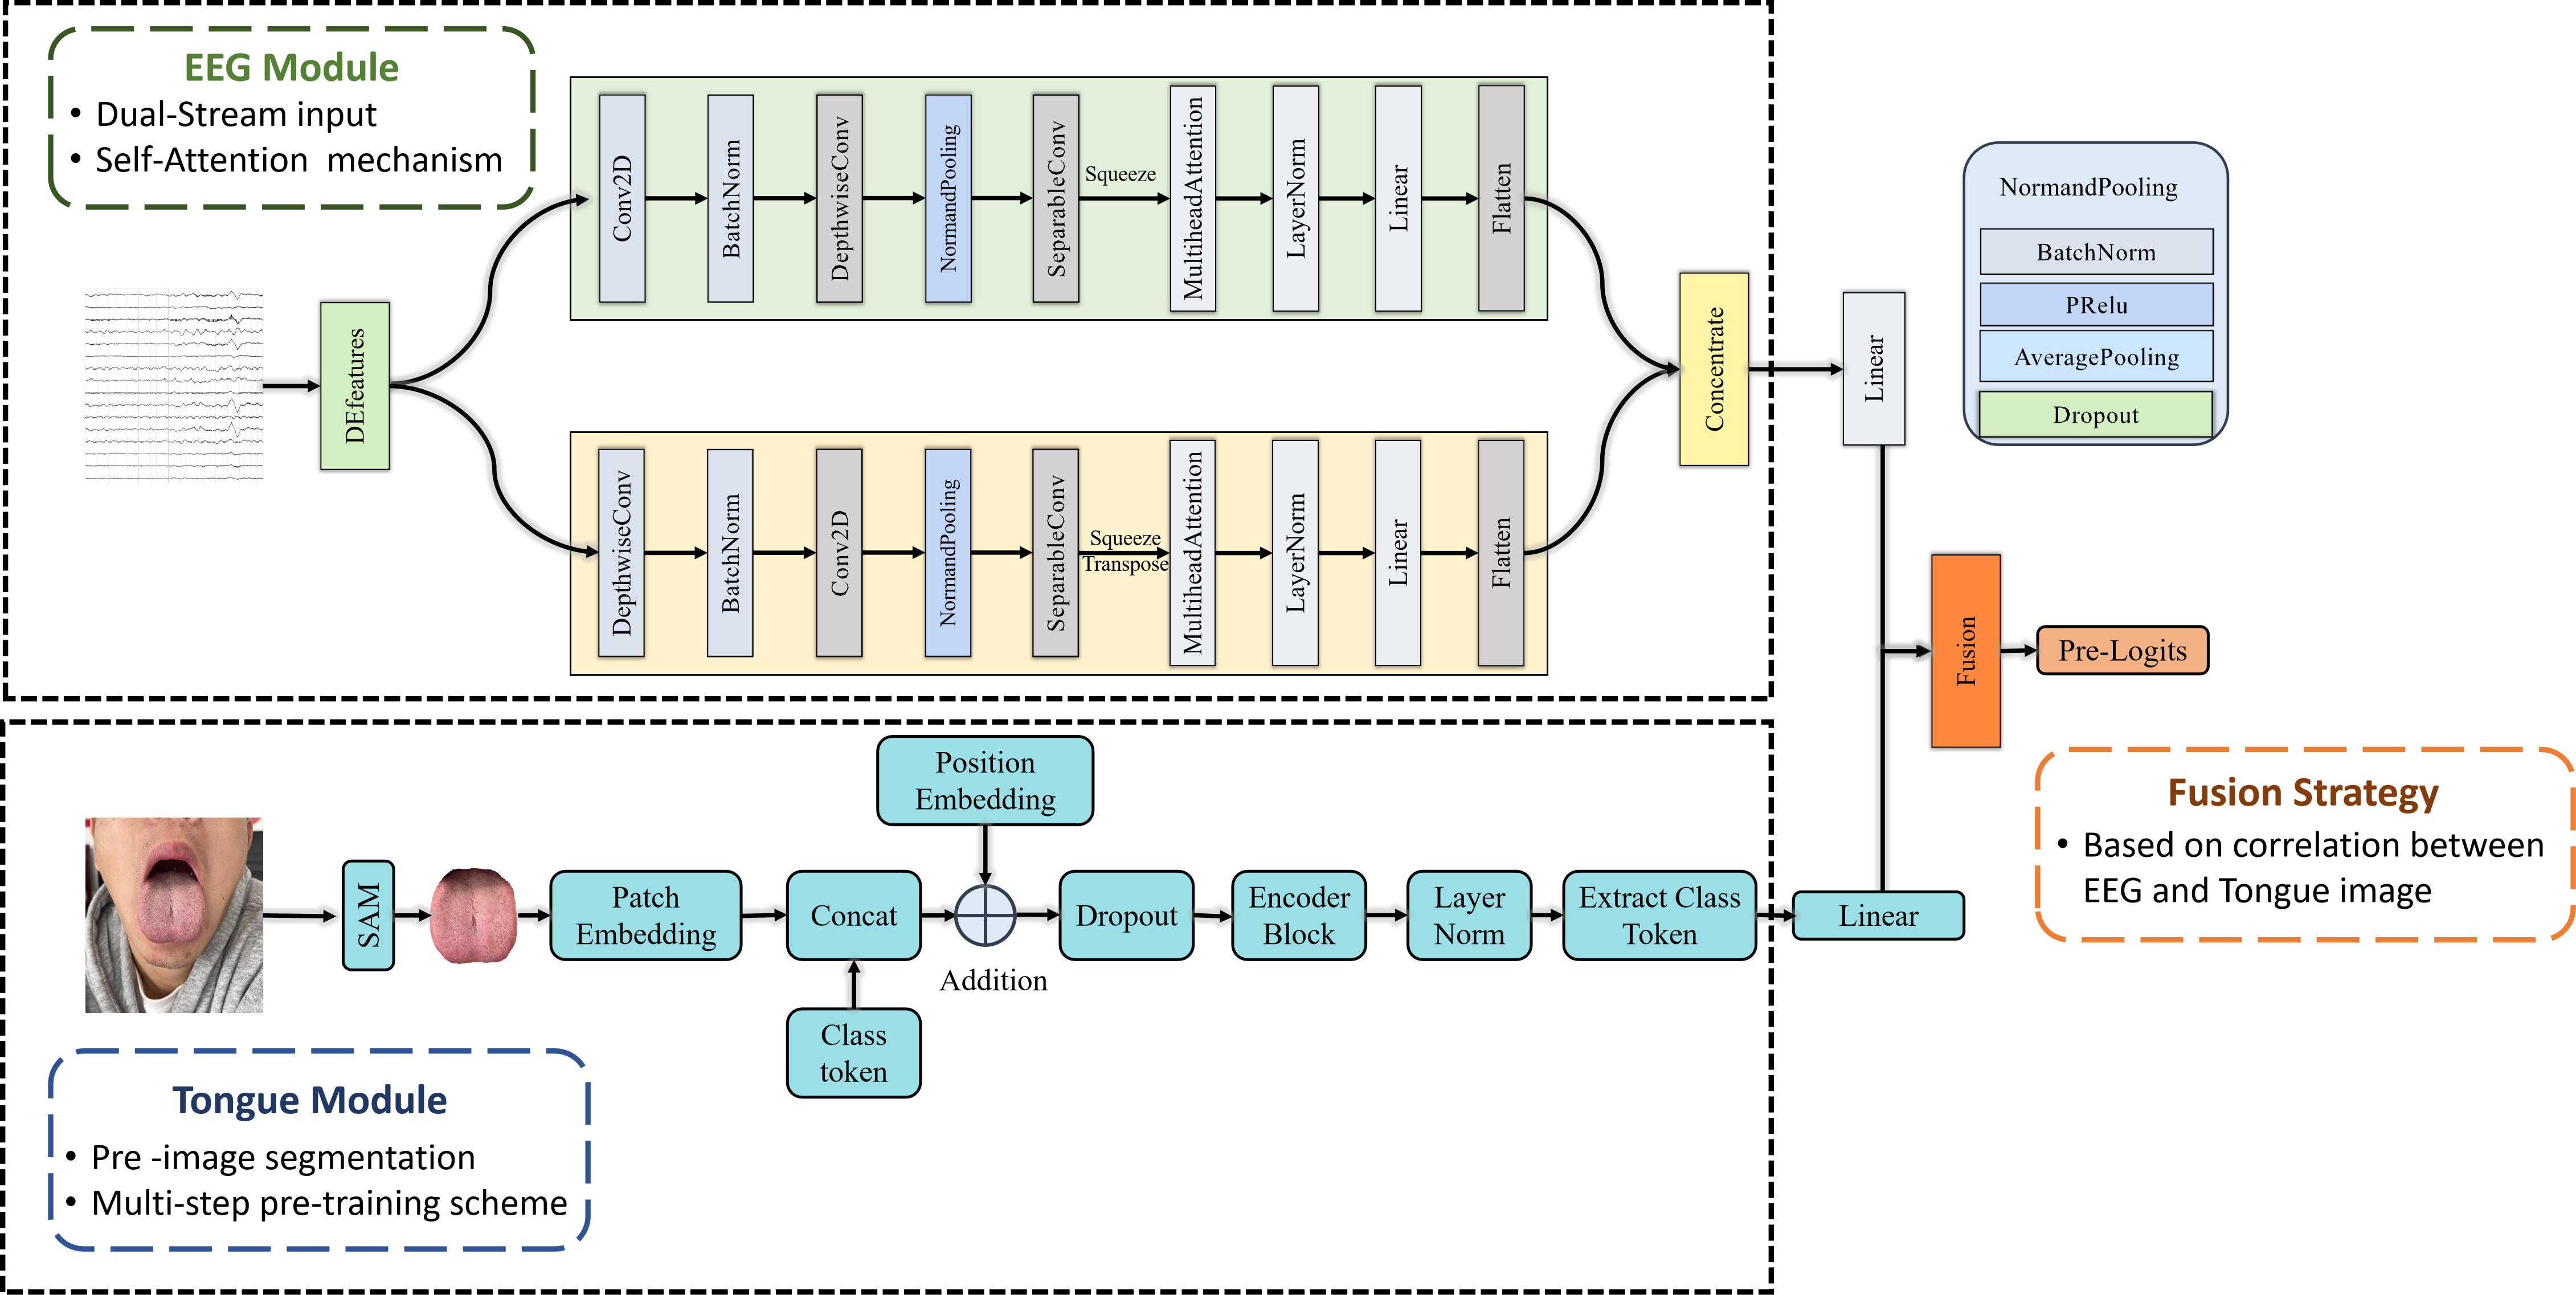

In [ ]:
#@title 架构Trans_EEGNet The architecture of Trans_EEGNet in EEG Module
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Concatenate,LayerNormalization
from tensorflow.keras.layers import PReLU,Add


def Trans_EEGNet(nb_classes, Chans = 64, Samples = 128,
             dropoutRate = 0.5, kernLength = 64, F1 = 8,
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """
    这个函数时基于EEGNet的添加了双流网络与自注意力机制的深度学习模型。该模型主要用于EEG信号的分类。
    A deep learning model based on Trans_EEGNet. This model is primarily used for the classification of EEG signals.

    参数(Args)：
    nb_classes: 类别的数量 the number of classes
    Chans: EEG信号的通道数 the number of channels of the EEG signal
    Samples: 每个通道的样本数量 the number of samples per channel
    dropoutRate: dropout层的丢失比例 the dropout rate of the dropout layer
    kernLength: 卷积核的长度 the length of the convolution kernel
    F1: 第一层卷积的滤波器数量 the number of filters in the first convolutional layer
    D: 深度卷积的深度倍数 the depth multiplier of the depthwise convolution
    F2: 第二层卷积的滤波器数量 the number of filters in the second convolutional layer
    norm_rate: 约束的最大范数 the max norm of the constraints
    dropoutType: Dropout的类型，可以为'SpatialDropout2D'或'Dropout'
    the type of Dropout, can be either 'SpatialDropout2D' or 'Dropout'


    """
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Chans, Samples, 1))
    block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(input1)
    block1   = BatchNormalization()(block1)
    block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
    block1   = BatchNormalization()(block1)
    block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
                alpha_constraint=None)(block1)
    block1   = AveragePooling2D((1, 4))(block1)
    block1   = dropoutType(dropoutRate)(block1)

    block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
    block2   = tf.squeeze(block2,[1])

    block2   = SelfAttention(block2.shape[-1], 4)(block2)
    block2   = Dense(block2.shape[-1]//2, name = 'dense1', kernel_constraint = max_norm(norm_rate))(block2)
    block2   = Flatten(name = 'flatten1')(block2)

    block3   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(input1)
    block3   = BatchNormalization()(block3)
    block3   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = block3.shape[1:], use_bias = False)(block3)
    block3   = BatchNormalization()(block3)
    block3   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
                alpha_constraint=None)(block3)
    block3   = AveragePooling2D((1, 4))(block3)
    block3   = dropoutType(dropoutRate)(block3)

    block4   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block3)
    block4   = tf.squeeze(block4,[1])
    block4   = tf.transpose(block4,perm= [0,2,1])

    block4   = SelfAttention(block4.shape[-1], 4)(block4)
    block4   = Dense(block4.shape[-1]//2, name = 'dense2', kernel_constraint = max_norm(norm_rate))(block4)
    block4   = Flatten(name = 'flatten2')(block4)

    flatten  = Concatenate(axis=-1)([block2, block4])
    dense   = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax  = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=input1, outputs=softmax)


model = Trans_EEGNet(2,kernLength=16)
# model.summary() #模型总结
test = tf.random.normal([5, 64, 128])
out = model(test)
test.shape,out.shape

(TensorShape([5, 64, 128]), TensorShape([5, 2]))

x shape  (110, 16, 74)
[0.1818181872367859, 0.1818181872367859, 0.27272728085517883, 0.5, 0.7727272510528564, 0.7727272510528564, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.9545454382896423, 0.9545454382896423, 0.9545454382896423, 0.95454543

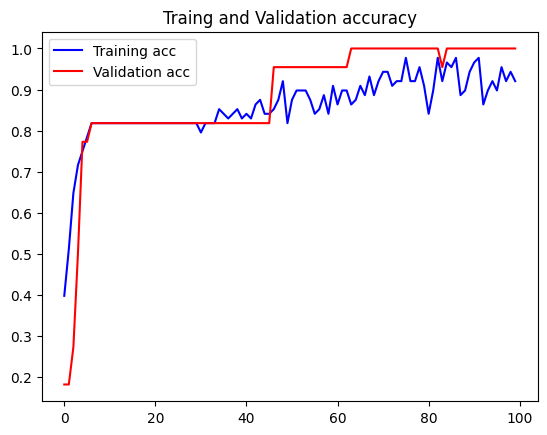

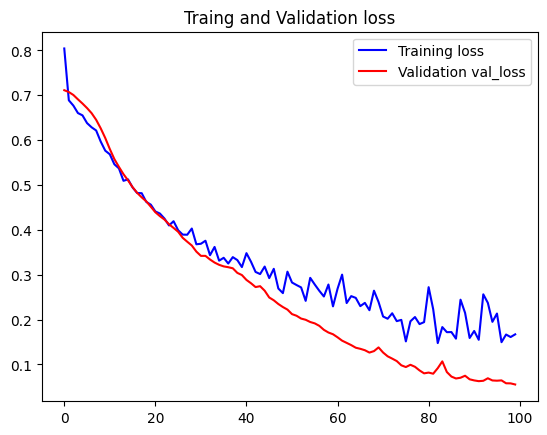

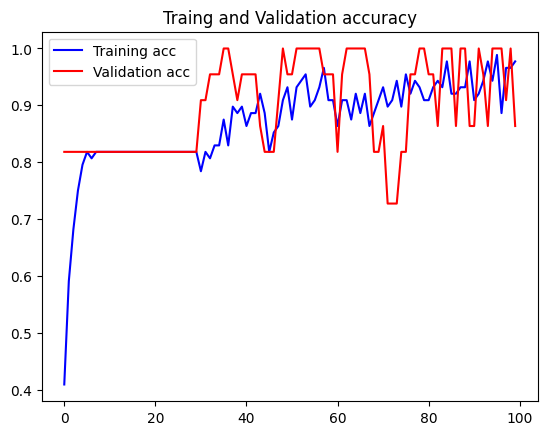

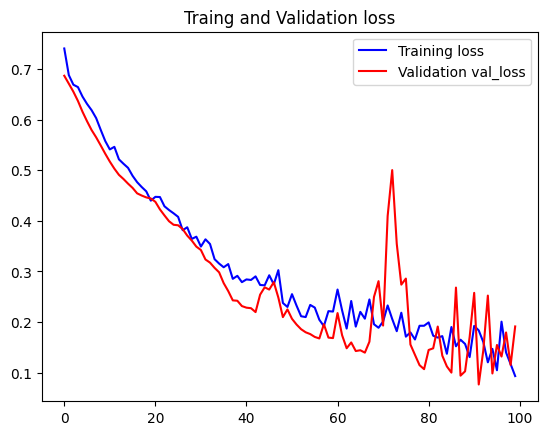

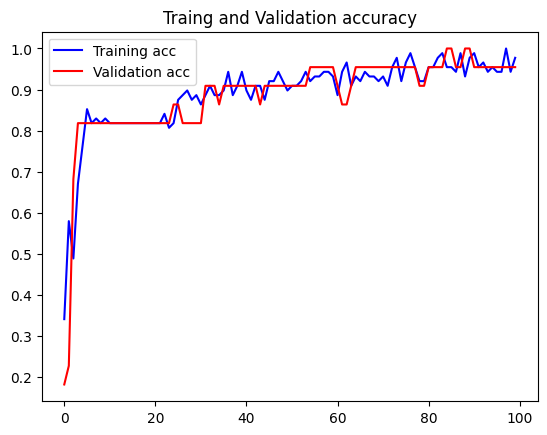

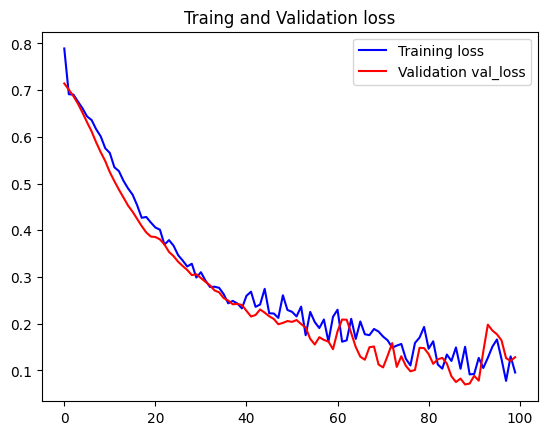

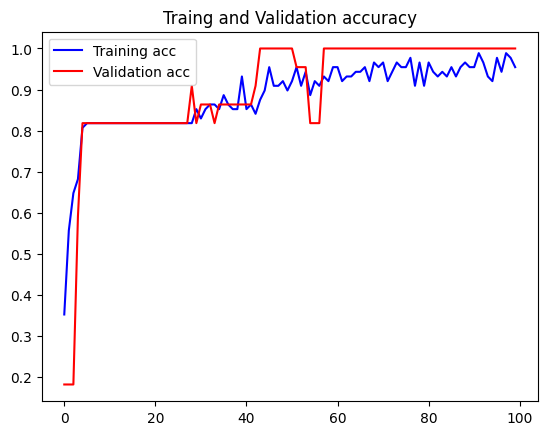

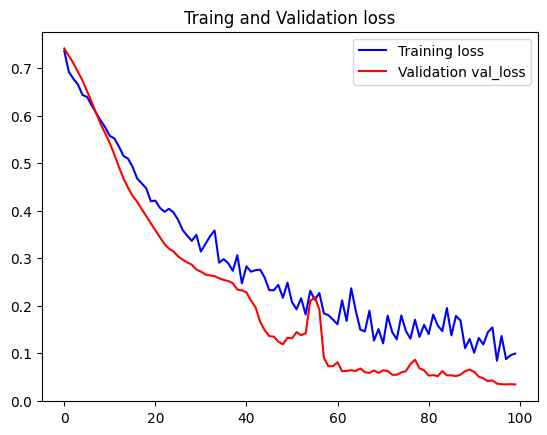

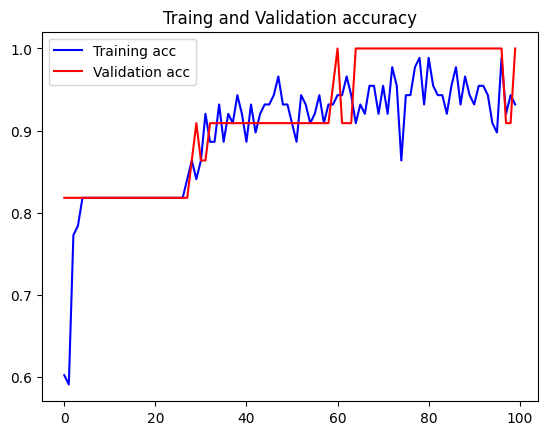

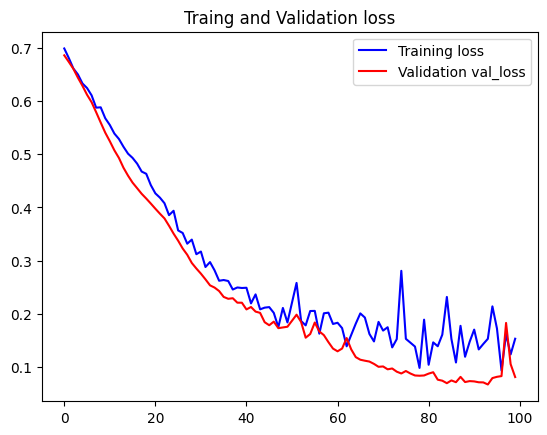

In [ ]:
#@title 单模态数据集上训练Trans_EEGNet Training Trans_EEGNet on a unimodal dataset
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

num_classes = 2
batch_size = 6
x = np.load('/content/drive/MyDrive/EEG_X_16ch.npy')
y = np.load('/content/drive/MyDrive/EEG_Y_16ch.npy')

x_alpha = x[:,:,:,2].transpose(0,2,1)
x = x_alpha
print("x shape ",x.shape)
y = to_categorical(y, num_classes)


seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model =Trans_EEGNet(nb_classes = 2, Chans = 16, Samples = 74,
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8,
                )
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam,
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  # #调超参 fine tune the parameter of kernelLength
  # model = KerasClassifier(build_fn=create_model, verbose=0)
  # kernLength = [10, 20, 25, 30, 50,100,150]
  # param_grid = dict(kernLength=kernLength)
  # grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
  # grid_result = grid.fit(x_train, y_train)

  # print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  # break;
  model = create_model(30)
  p= p+1
  history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Traing and Validation accuracy')
  plt.legend()
  # plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Traing and Validation loss')
  plt.legend()
  # plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_loss.jpg')


  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)

print("mean final acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))


In [ ]:
#@title 加载flowers102数据集以进行舌模块的元学习训练 Load the flowers102 dataset for meta-learning training of the tongue module
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras import layers
dataset_repetitions = 5
batch_size = 64
image_size = 224
def preprocess_image(data):
    """
    这个函数用于预处理图像数据，并返回处理后的图像和标签。

    参数(Args):
        data (dict): 包含图像和标签的数据字典。

    这个函数会执行以下操作:
    This function performs the following operations:
        1. 调整图像大小为指定的image_size，并进行抗锯齿处理。
        2. 获取图像的标签。
        3. 将图像像素值裁剪到0.0到1.0的范围内。
        4. 返回处理后的图像和标签。

    返回(Returns):
        image (tf.Tensor): 处理后的图像数据，像素值范围为0.0到1.0。
        labels (tf.Tensor): 图像的标签。
    """
    image = tf.image.resize(data["image"], size=[image_size, image_size], antialias=True)
    labels = data["label"]
    return tf.clip_by_value(image / 255.0, 0.0, 1.0),labels

def prepare_dataset(split):
    """
    这个函数用于准备数据集并进行预处理。

    参数(Args):
        split (str): 数据集的划分方式。

    这个函数会执行以下操作:
    This function performs the following operations:
        1. 加载"oxford_flowers102"数据集，并根据给定的划分方式加载对应的数据集子集。
        2. 调用preprocess_image函数对每个图像进行预处理，使用tf.data.Dataset.map函数进行并行处理。

    返回(Returns):
        dataset (tf.data.Dataset): 处理后的数据集。
    """
    return (
        tfds.load("oxford_flowers102", split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    )

train_set = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")

In [ ]:
#@title 读入flowers数据,构造锚点及正负样本组 Read in flowers data, construct anchor points and positive and negative sample groups
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import Callable
from collections import defaultdict
import random
import warnings
flowers_data = train_set

def create_emb_model_data_reader(chosen_classes: int = 5, batch_size: int = 32,
                                 num_batches: int = 100):
    """
    这个函数用于创建并读取用于嵌入模型训练的数据集。

    参数(Args):
        chosen_classes (int): 选择的类别数，默认为5。
        batch_size (int): 批次大小，默认为32。
        num_batches (int): 批次数量，默认为100。

    这个函数会执行以下操作:
    This function performs the following operations:
        1. 检查chosen_classes必须大于等于2，因为训练数据必须包含相同和不同类别的图像。
        2. 检查batch_size必须是偶数。
        3. 读取特征提取模型的训练数据集。
        4. 根据chosen_classes筛选出指定数量的数据。
        5. 根据类别将图像分组。
        6. 为每个批次定义一个numpy数组以存储数据。
        7. 随机选择类别和图像，并构建包含锚点图像、正样本图像和负样本图像的批次数据。
        8. 对批次数据进行转置和重塑。
        9. 返回批次数据和相应的标签。

    返回(Returns):
        X (list): 包含锚点图像、正样本图像和负样本图像的列表。
        Y (numpy.ndarray): 相应的标签，全部为0。
    """
    assert chosen_classes >= 2, 'Training data must contain images of same and different classes, ' \
                                'hence number of classes must be greater than or equal to 2, ' \
                                'but got chosen_classes parameter value: {}'.format(chosen_classes)
    assert batch_size % 2 == 0, 'Batch size must be even, but got batch_size parameter value: ' \
                                '{}'.format(batch_size)
    print('正在读取特征提取模型训练数据集……')
    mini_flowers_data = []
    for flower_data in flowers_data:
        if flower_data[1].numpy() <= chosen_classes:
            mini_flowers_data.append(flower_data)
    print('读取数据完毕！')
    # Grouping images by class
    class_idx_to_image_idxs = defaultdict(list)
    for image, label in mini_flowers_data:
        class_idx_to_image_idxs[label.numpy()].append(image)
    print(class_idx_to_image_idxs.keys())

    X = np.empty((num_batches,batch_size // 2,3,224,224,3))
    for _ in range(num_batches):
        # Defining a numpy array to store a batch data
        # Each data contains one anchor image, one positive image and one negative image
        x = np.empty((3, batch_size // 2, 224, 224, 3), dtype='float32')

        for batch_image_idx in range(batch_size // 2):
            # Selecting two categories of image classes to extract from
            images_class_idxs = list(class_idx_to_image_idxs.keys())

            base_class_idx = random.choice(images_class_idxs)
            negative_class_idx = random.choice(images_class_idxs)
            while base_class_idx == negative_class_idx:
                negative_class_idx = random.choice(images_class_idxs)

            base_examples_for_class = class_idx_to_image_idxs[base_class_idx]
            negative_examples_for_class = class_idx_to_image_idxs[negative_class_idx]

            # Randomly selecting images
            anchor_image_idx = random.choice(range(len(base_examples_for_class)))
            positive_image_idx = random.choice(range(len(base_examples_for_class)))
            while positive_image_idx == anchor_image_idx: #保证同类不同图 Ensure that the two samples belong to the same category but are different images
                positive_image_idx = random.choice(range(len(base_examples_for_class)))
            negative_image_idx = random.choice(range(len(negative_examples_for_class)))

            x[0, batch_image_idx] = base_examples_for_class[anchor_image_idx]
            x[1, batch_image_idx] = base_examples_for_class[positive_image_idx]
            x[2, batch_image_idx] = negative_examples_for_class[negative_image_idx]
        x = x.transpose(1,0,2,3,4)
        X[_] = x
    X = X.reshape(-1,3,224,224,3)
    Y = np.zeros([X.shape[0]])
    return [X[:,0],X[:,1],X[:,2]],Y

In [ ]:
#@title 架构Vit(加载imagenet预训练权重后冻结该部分权重) The architecture of Vit in Tongue Module(Freeze the imagenet pre-training weights after loading them)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Concatenate,LayerNormalization
from tensorflow.keras.layers import PReLU,Add
from vit_keras import vit

def vit_test(embedding_dim = 144):
  image_input = Input(shape=(224, 224, 3))
  base_model = vit.vit_b16(classes = 1000,pretrained=True)
  for layer in base_model.layers[:]:
    layer.trainable = False
  image = base_model(image_input)
  image = Dense(embedding_dim,name = 'dancedense',use_bias=True, #是否使用b
  kernel_initializer='glorot_uniform', #初始化w权重，keras/initializers.py
  bias_initializer='zeros')(image)
  image = image / K.expand_dims(K.sqrt(K.sum(K.square(image), axis=1)), axis=1) #L2 Norm
  return Model(inputs=image_input,outputs= image)


In [ ]:
#@title 元学习:flowers数据集上训练图片特征提取网络 Meta-learning:Training an image feature extraction network on the flowers dataset
import tensorflow as tf
import numpy as np
from typing import Callable
from collections import defaultdict
import random
import warnings
from tensorflow.keras.layers import Concatenate,LayerNormalization


def train_emb_model(epochs: int,
                    batch_size: int,
                    learning_rate: float,
                    Xlist,Y,
                    embedding_dim: int = 144) -> None:
    """
    训练图片特征提取网络。
    Train the image feature extraction network.

    参数(Args)：
        epochs (int): 生成的训练数据集迭代的次数。
        batch_size (int): 每个批次的数据量。
        learning_rate (float): 优化器的学习率。
        Xlist: 输入数据的列表。
        Y: 输出标签。
        embedding_dim (int): 将图片转换为特征向量的维度。

    返回值(Returns)：
        None
    """
    # loss 函数
    def triplet_loss(y_true, y_pred):
      """
        Triplet损失函数的实现。
        Implementation of the triplet loss function

        参数(Args)：
            y_true: 真实标签，在Keras中定义损失函数时需要，但在此函数中不需要。
                true labels, required when you define a loss in Keras,
                you don't need it in this function.
            y_pred: 包含三个对象的Python列表：
                    anchor - 锚点数据的编码
                    positive - 正样本数据的编码（与锚点相似）
                    negative - 负样本数据的编码（与锚点不同）
              python list containing three objects:
              anchor -- the encodings for the anchor data
              positive -- the encodings for the positive data
              (similar to anchor)
              negative -- the encodings for the negative data
              (different from anchor)

        返回值(Returns)：
            loss: 实数，损失值。 real number, value of the loss
      """
      anchor = y_pred[:, 0:embedding_dim]
      positive = y_pred[:, embedding_dim:2*embedding_dim]
      negative = y_pred[:, 2*embedding_dim:3*embedding_dim]
      label = tf.concat([tf.ones([batch_size, ]), tf.zeros([batch_size, ])], axis=0)
      positives_similarity = tf.keras.losses.cosine_similarity(anchor,positive) # 32
      negatives_similarity = tf.keras.losses.cosine_similarity(anchor,negative) # 32
      similarity = tf.concat([positives_similarity, negatives_similarity], axis=0)
      # print(similarity.shape)
      loss = tf.keras.losses.mse(similarity, label)

      return loss

    # 模型定义
    emb_model = vit_test(embedding_dim=embedding_dim)

    for layer in emb_model.layers[:]:
      if layer.name == 'dancedense':
        layer.trainable = True
    # emb_model.summary()
    # 定义优化器，只训练fc层参数 only train the full-connect layer
    anchor_in = Input(shape=(224, 224, 3))
    pos_in = Input(shape=(224, 224, 3))
    neg_in = Input(shape=(224, 224, 3))

    anchors_embedding = emb_model(anchor_in)
    positives_embedding = emb_model(pos_in)
    negatives_embedding = emb_model(neg_in)

    merged_vector = Concatenate(axis=-1)([anchors_embedding, positives_embedding, negatives_embedding])

    # Define the trainable model
    model = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss=triplet_loss)
    model.fit(Xlist, Y, batch_size, epochs,verbose = 1)
    model.summary()
    model.save('models/emb_model.h5')

# 训练特征提取网络
emb_epochs = 10
emb_batch_size = 32
emb_learning_rate = 0.0005
chosen_classes = 25
# 创建训练数据读取器
Xlist,Y = create_emb_model_data_reader(chosen_classes=chosen_classes, batch_size=emb_batch_size)
print(Xlist[0].shape)

print(Y.shape)
Y = tf.convert_to_tensor(Y)
newA = tf.convert_to_tensor(Xlist[0])
newP = tf.convert_to_tensor(Xlist[1])
newN = tf.convert_to_tensor(Xlist[2])
X = [newA,newP,newN]

train_emb_model(epochs=emb_epochs, batch_size=emb_batch_size, learning_rate=emb_learning_rate,
                Xlist=X,Y=Y)

In [ ]:
#@title 使用剩余舌象图片进行最后一步预训练 Use the remaining tongue images for the final pre-training step

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout

inputPics = Input(shape=(224, 224, 3))
emb_model = vit_test(embedding_dim=144)
mid = emb_model(inputPics)
mid = Dense(2,name = 'dancedense2')(mid)
mid = Activation('softmax', name = 'dancesoftmax')(mid)
model = Model(inputs=inputPics, outputs=mid)
model.load_weights('models/emb_model.h5',by_name=True, skip_mismatch=True)


pics = np.load('/content/drive/MyDrive/SE_pics_pretrained.npy')
pics = pics.transpose((0,2,3,1))
y = np.load('/content/drive/MyDrive/SE_Y_16ch_pretrained.npy')
y = to_categorical(y,2)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),loss='categorical_crossentropy')
model.fit(pics,y,8,100,verbose = 1)
model.summary()
model.save('models/new_emb_model.h5')

In [ ]:
#@title 多模态数据集上训练MMTV Training MMTV on the multimodal dataset
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Conv2D, MaxPooling2D, Flatten, Concatenate
from keras.models import Model
import numpy as np
from vit_keras import vit
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


def MMTV(nb_classes = 2,Chans = 64, Samples = 128, dropoutRate = 0.5, kernLength = 64, F1 = 8,
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
  """
   MMTV是一个处理图像和序列数据的深度学习模型，它由Trans_EEGNet部分以及经历了三步预训练方案的ViT构成。

    MMTV is a deep learning model for handling image and sequence data, composed of the
    Trans_EEGNet part and ViT that has undergone a three-step pre-training scheme.

  参数(Args)：
  nb_classes: 类别的数量 the number of classes
  Chans: EEG信号的通道数 the number of channels of the EEG signal
  Samples: 每个通道的样本数量 the number of samples per channel
  dropoutRate: dropout层的丢失比例 the dropout rate of the dropout layer
  kernLength: 卷积核的长度 the length of the convolution kernel
  F1: 第一层卷积的滤波器数量 the number of filters in the first convolutional layer
  D: 深度卷积的深度倍数 the depth multiplier of the depthwise convolution
  F2: 第二层卷积的滤波器数量 the number of filters in the second convolutional layer
  norm_rate: 约束的最大范数 the max norm of the constraints
  dropoutType: Dropout的类型，可以为'SpatialDropout2D'或'Dropout'
  the type of Dropout, can be either 'SpatialDropout2D' or 'Dropout'


  """
  sequence_input = Input(shape=(Chans, Samples, 1))
  if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
      dropoutType = Dropout
  else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                        'or Dropout, passed as a string.')

  block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(sequence_input)
  block1   = BatchNormalization()(block1)
  block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
  block1   = BatchNormalization()(block1)
  block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block1)
  block1   = AveragePooling2D((1, 4))(block1)
  block1   = dropoutType(dropoutRate)(block1)

  block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
  block2   = tf.squeeze(block2,[1])
  block2   = SelfAttention(block2.shape[-1], 4)(block2)
  block2   = Dense(block2.shape[-1]//2, name = 'dense1', kernel_constraint = max_norm(norm_rate))(block2)
  block2   = Flatten(name = 'flatten1')(block2)

  block3   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(sequence_input)
  block3   = BatchNormalization()(block3)
  block3   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = block3.shape[1:], use_bias = False)(block3)
  block3   = BatchNormalization()(block3)
  block3   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block3)
  block3   = AveragePooling2D((1, 4))(block3)
  block3   = dropoutType(dropoutRate)(block3)

  block4   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block3)
  block4   = tf.squeeze(block4,[1])
  block4   = tf.transpose(block4,perm= [0,2,1])
  block4   = SelfAttention(block4.shape[-1], 4)(block4)
  block4   = Dense(block4.shape[-1]//2, name = 'dense2', kernel_constraint = max_norm(norm_rate))(block4)
  block4   = Flatten(name = 'flatten2')(block4)

  sequence_output  = Concatenate(axis=-1)([block2, block4])

  image_input = Input(shape=(224, 224, 3))
  emb_model = vit_test(embedding_dim=144)
  image = emb_model(image_input)

  concatenated_output = Concatenate()([sequence_output, image])
  dense        = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(concatenated_output)
  softmax = Activation('softmax', name = 'softmax')(dense)
  return Model(inputs=[sequence_input, image_input], outputs=softmax)

num_classes = 2
batch_size = 6
x = np.load('/content/drive/MyDrive/SE_X_16ch.npy')
y = np.load('/content/drive/MyDrive/SE_Y_16ch.npy')
pics = np.load('/content/drive/MyDrive/SE_pics.npy')
x_alpha = x[:,:,:,2].transpose(0,2,1)
x = x_alpha
print("x shape ",x.shape)
y = to_categorical(y, num_classes)
pics = pics.transpose((0,2,3,1))
print("pics shape ",pics.shape)

seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
all_acc = []
p = 0

def create_model(kernLength):
  model = MMTV(nb_classes = 2, Chans = 16, Samples = 74, dropoutRate = 0.5,
                      kernLength = kernLength, F1 = 4, D = 8, F2 = 8)
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam,
              metrics = ['accuracy'])
  return model


for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  pic_train = pics[train]
  x_test = x[test]
  y_test = y[test]
  pic_test = pics[test]
  model = create_model(30)
  model.load_weights('/content/drive/MyDrive/new_emb_model.h5',by_name=True, skip_mismatch=True)
  p= p+1
  history = model.fit([x_train,pic_train], y_train, epochs=100, batch_size=batch_size,
                      verbose=0,validation_data = ([x_test,pic_test],y_test))


  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)

print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


x shape  (110, 16, 74)
pics shape  (110, 224, 224, 3)


KeyboardInterrupt: ignored